In [9]:
import collections
import itertools
import logging
import random
import sys
from collections import deque
from datetime import datetime

from copy import deepcopy

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import gym
import pfrl

import torch
from tqdm import tqdm

from torch import nn
from gym.wrappers import RescaleAction

from util.ppo import PPO_KL
from util.modules import ortho_init, BetaPolicyModel
from util.env import VisionEnvWrapper, to_multi_modal
from conditioned_trp_env.envs.conditioned_trp_env import FoodClass


seed = 100

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)


########################################
# Environment
########################################

n_channel = 4
n_frame_stack = 3
dim_vision_flatten = 200
im_size = (64, 64)

TIME_STEPS = 300
NUM_TICK = 21
# NUM_TICK = 11

NUM_SAMPLE = 100

RADIUS = 5
NUM_FOOD = 6

# red_ticks = np.linspace(-0.5, 0.5, NUM_TICK)
# blue_ticks = np.linspace(-0.5, 0.5, NUM_TICK)

red_ticks = np.linspace(-1.0, 1.0, NUM_TICK)
blue_ticks = np.linspace(-1.0, 1.0, NUM_TICK)

# red_ticks = np.linspace(-0.3, 0.3, NUM_TICK)
# blue_ticks = np.linspace(-0.3, 0.3, NUM_TICK)

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

env = gym.make(
    "conditioned_trp_env:SmallLowGearAntCTRP-v0",
    max_episode_steps=np.inf,
    internal_reset="setpoint",
    n_bins=2,
    sensor_range=0.1,
)
env = RescaleAction(env, 0, 1)
env = VisionEnvWrapper(env, im_size=im_size, n_frame=n_frame_stack, mode="rgbd_array")
env = pfrl.wrappers.CastObservationToFloat32(env)


########################################
# Agent
########################################

obs_size_prop = 27
obs_size_intero = 2
action_size = 8

# vision encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.flatten_size = 26912  # 35 * 35 * 32

        # random shift augmentation
        #self.aug = RandomShiftsAug(pad=2)

        self.vision_encoder = nn.Sequential(
            nn.Conv2d(in_channels=n_channel * n_frame_stack, out_channels=32, kernel_size=3, stride=2, bias=False),
            nn.ELU(inplace=True),
            nn.Conv2d(32, 32, 3, stride=1, bias=False),
            nn.ELU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=self.flatten_size, out_features=dim_vision_flatten),
            nn.LayerNorm(normalized_shape=dim_vision_flatten),
            nn.Tanh()
        )

        # Initialization
        for l in self.vision_encoder:
            if isinstance(l, nn.Conv2d):
                gain = nn.init.calculate_gain('relu')
                nn.init.orthogonal_(l.weight, gain=gain)
                if hasattr(l.bias, "data"):
                    l.bias.data.fill_(0.0)
            if isinstance(l, nn.Linear):
                nn.init.orthogonal_(l.weight, gain=1)
                nn.init.zeros_(l.bias)
            
    def forward(self, x, enable_aug=False):
        x_prop, x_intero, x_vision = to_multi_modal(x,
                                                    im_size=im_size,
                                                    n_frame=n_frame_stack,
                                                    n_channel=n_channel)

#         if enable_aug:
#             x_vision = self.aug(x_vision.float())

        feature_vision = self.vision_encoder(x_vision)
        # print("feature", feature_vision.shape)

        return feature_vision, x_prop, x_intero


dim_joint_feature = dim_vision_flatten + 27 + 2


# compose a total model
class FFModel(nn.Module):
    def __init__(self):
        super(FFModel, self).__init__()

        self.encoder = Encoder()

        self.policy_network = BetaPolicyModel(obs_size=dim_joint_feature,
                                              action_size=action_size,
                                              activation=nn.Tanh,
                                              hidden1=300,
                                              hidden2=200)

        self.value_network = nn.Sequential(
            nn.Linear(dim_joint_feature, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 1)
        )

        ortho_init(self.value_network[0], gain=1)
        ortho_init(self.value_network[2], gain=1)
        ortho_init(self.value_network[4], gain=1)

    def forward(self, x, enable_aug=False):
        # enable data augmentation while training
        feature_vision, x_prop, x_intero = self.encoder(x, enable_aug)

        # policy path (removing detach op for vision)
        x_policy = torch.cat((feature_vision, x_prop, x_intero), dim=1)
        distribs = self.policy_network(x_policy)

        # value path
        x_value = torch.cat((feature_vision, x_prop, x_intero), dim=1)
        vs_pred = self.value_network(x_value)

        return (distribs, vs_pred)



model = FFModel()

opt = torch.optim.Adam(model.parameters())

if torch.cuda.is_available():
    gpu_id = 1
    print(torch.cuda.get_device_name(gpu_id))
else:
    gpu_id = None

agent = PPO_KL(
    model=model,
    optimizer=opt,
    gpu=gpu_id,
)

param_dirs = [
#     "data/vision-homeostatic_shaped2021-11-17-17-05-57/28000000_except" # preliminary result
    "data/success_vision/vision-homeostatic_shaped2021-11-26-14-13-12/20000000_finish/",
    "data/success_vision/vision-homeostatic_shaped2021-11-26-14-16-12/20000000_finish/",
    "data/success_vision/vision-homeostatic_shaped2021-12-02-10-54-22/20000000_finish/",
]

GeForce GTX 1050 Ti


In [ ]:
# TODO delete this
tmp_id = 2

for id_, d in enumerate(param_dirs):
    
    agent.load(d, 0)
    
    data_red_matrix = np.zeros(shape=(NUM_TICK, NUM_TICK))
    data_blue_matrix = np.zeros(shape=(NUM_TICK, NUM_TICK))
    
    print(f"START NEW PARAM: {d}")

    for i, blue in enumerate(blue_ticks):
        for j, red in enumerate(red_ticks):

            obs = None

            for n in range(NUM_SAMPLE):
                obs = env.reset(initial_internal=(blue, red),
                                object_positions={"blue": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)],
                                                  "red": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)]})

                for _ in range(TIME_STEPS):
                    with torch.no_grad():
                        action = agent.act(obs)
                    
                    obs, reward, done, info = env.step(action)
                    #env.render()

                    if done:
                        if info.get("food_type") == FoodClass.RED:
                            data_red_matrix[i, j] += 1
                        elif info.get("food_type") == FoodClass.BLUE:
                            data_blue_matrix[i, j] += 1
                        break

            print(f"{id_ + tmp_id + 1}/{len(param_dirs)} - internal @ {i*NUM_TICK + (j + 1)}/{NUM_TICK**2}: (blue, red) = ({blue}, {red}) [RESULT: blue/red: {int(data_blue_matrix[i, j])}/{int(data_red_matrix[i, j])}] ")


    data_red_matrix /= NUM_SAMPLE
    data_blue_matrix /= NUM_SAMPLE

    print(data_red_matrix)
    print(data_blue_matrix)

    # SAVE RESULTS
    np.save(f"data_matrices_blue_{id_ + tmp_id}_vision_full.npy", data_blue_matrix)
    np.save(f"data_matrices_red_{id_ + tmp_id}_vision_full.npy", data_red_matrix)

START NEW PARAM: data/success_vision/vision-homeostatic_shaped2021-11-26-14-13-12/20000000_finish/


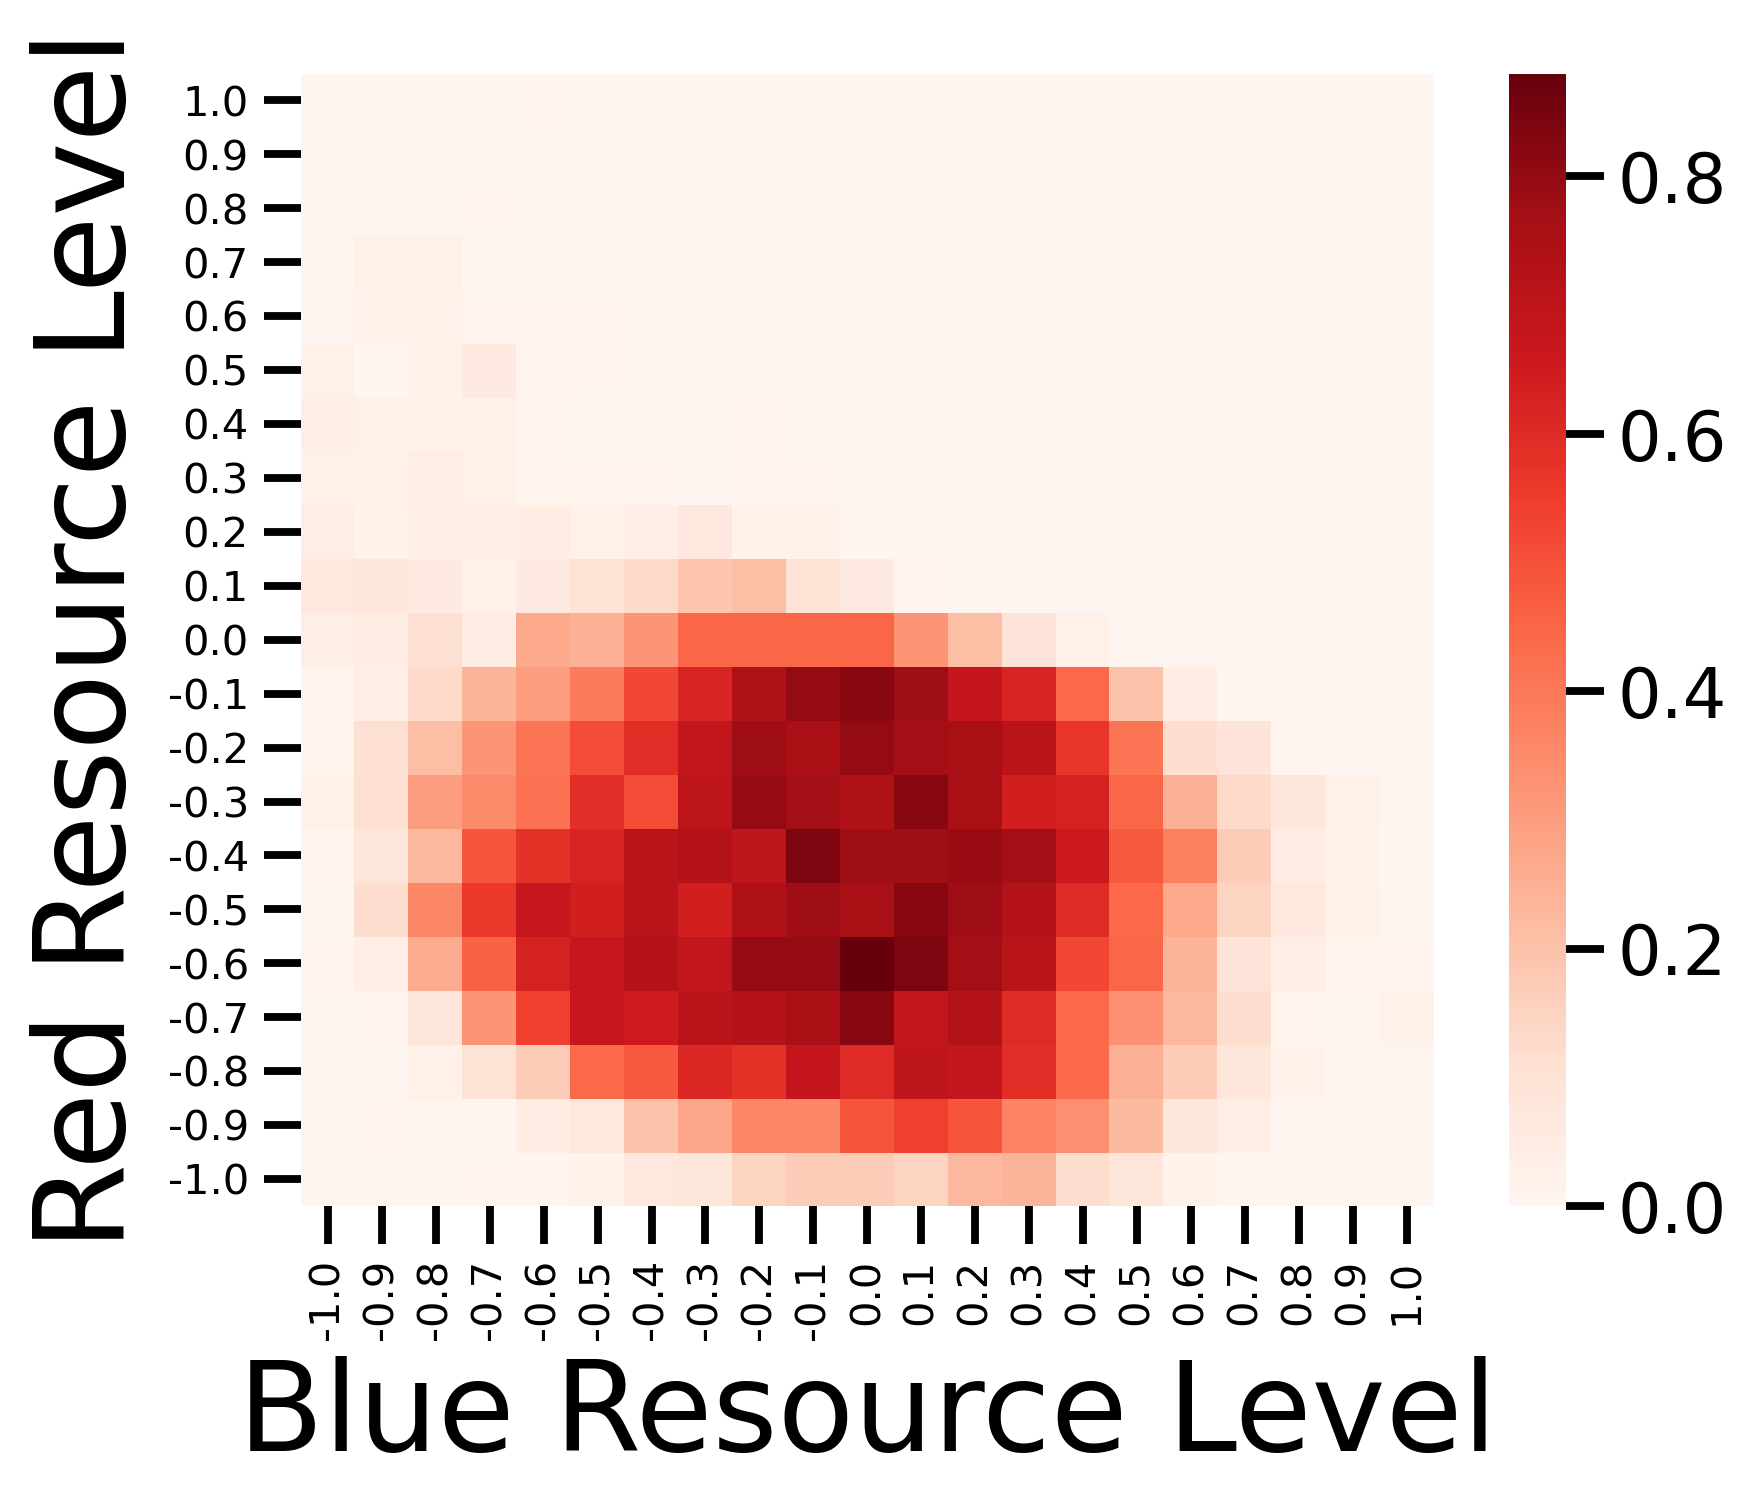

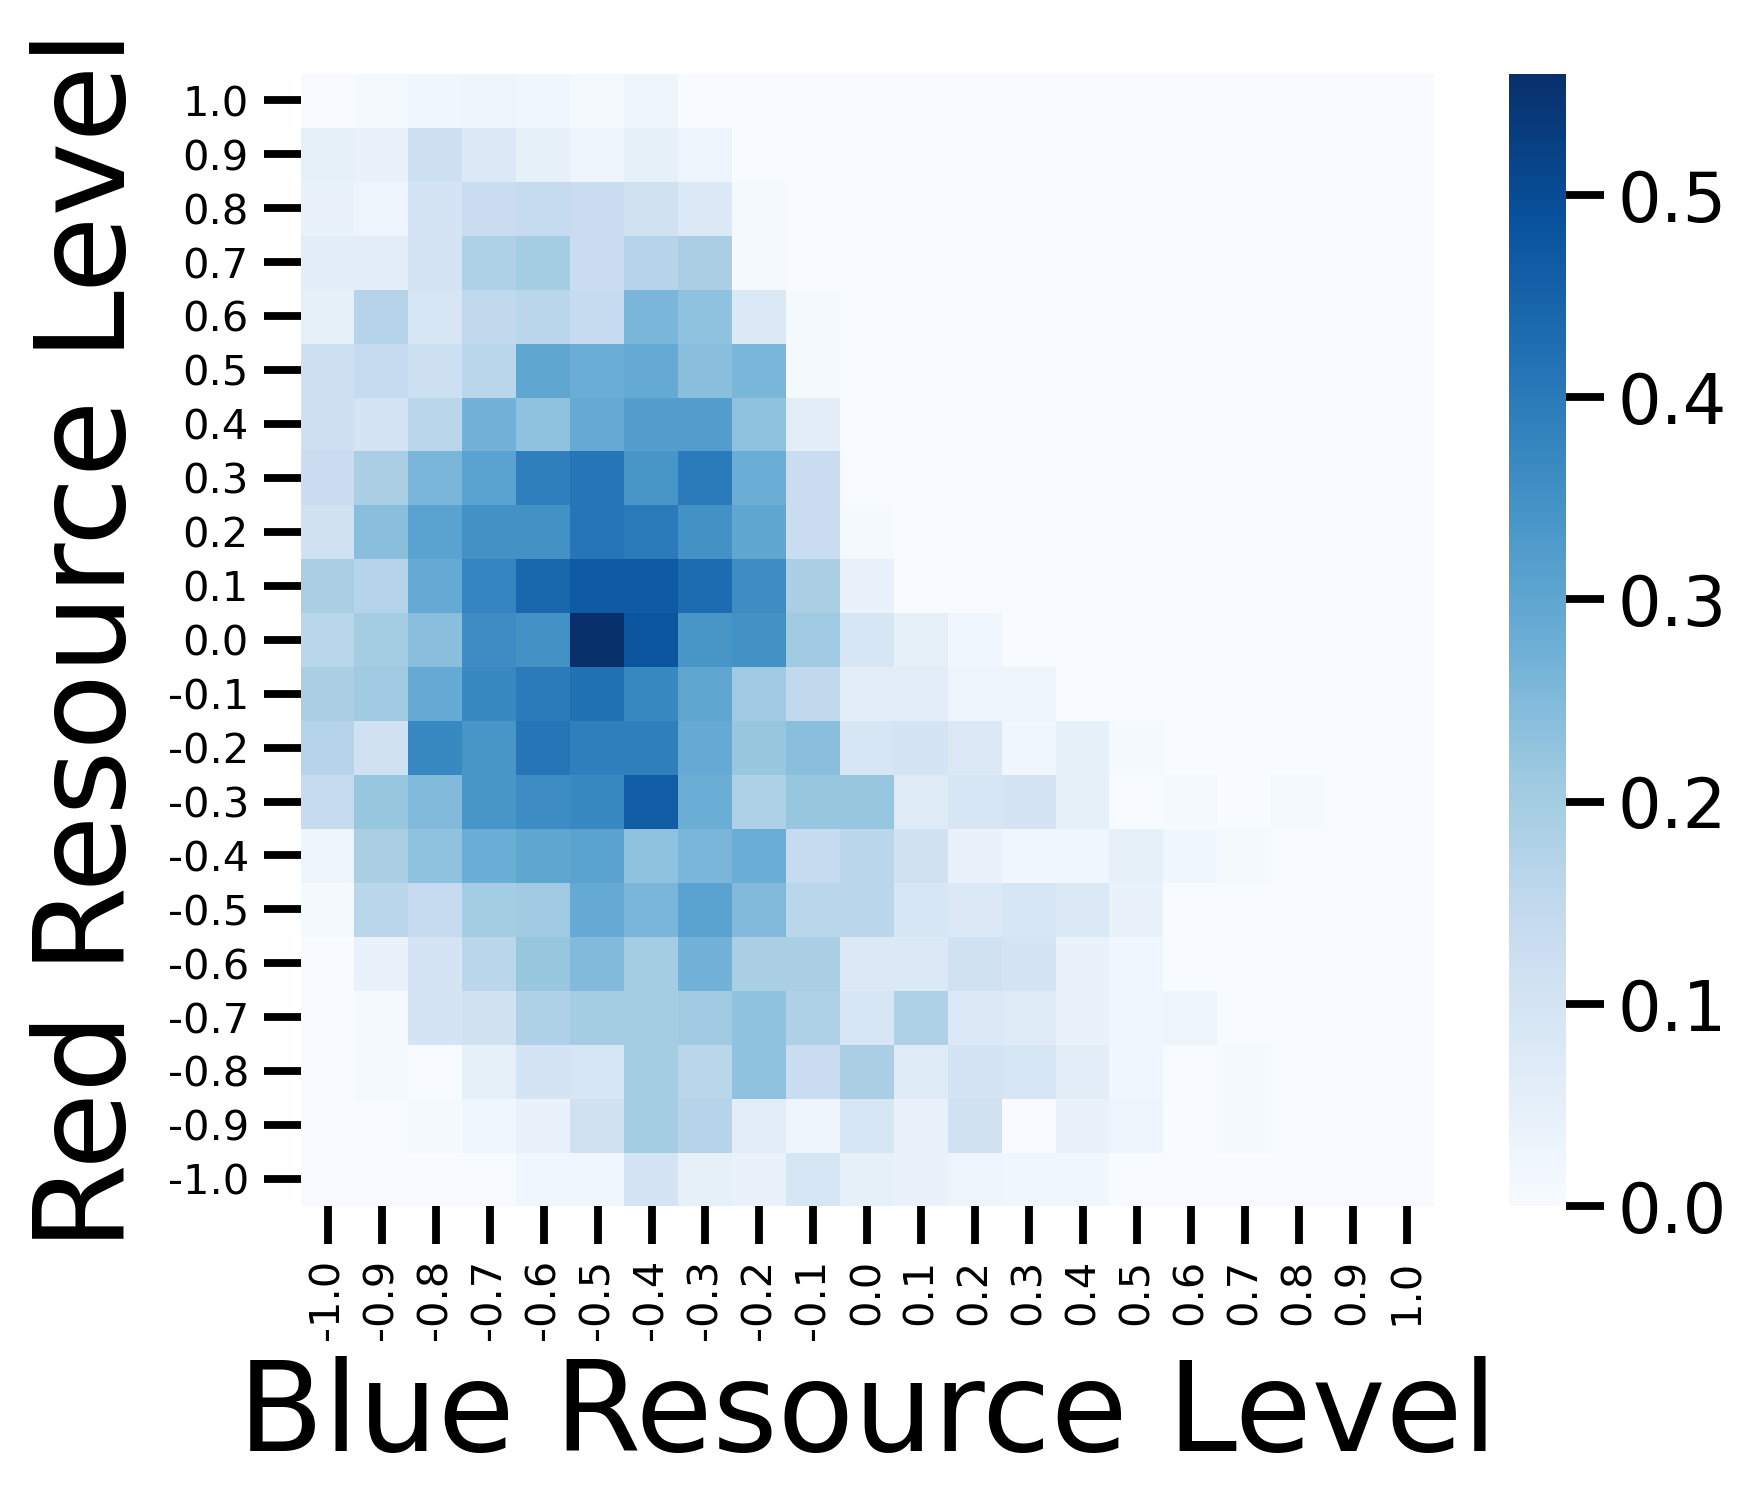

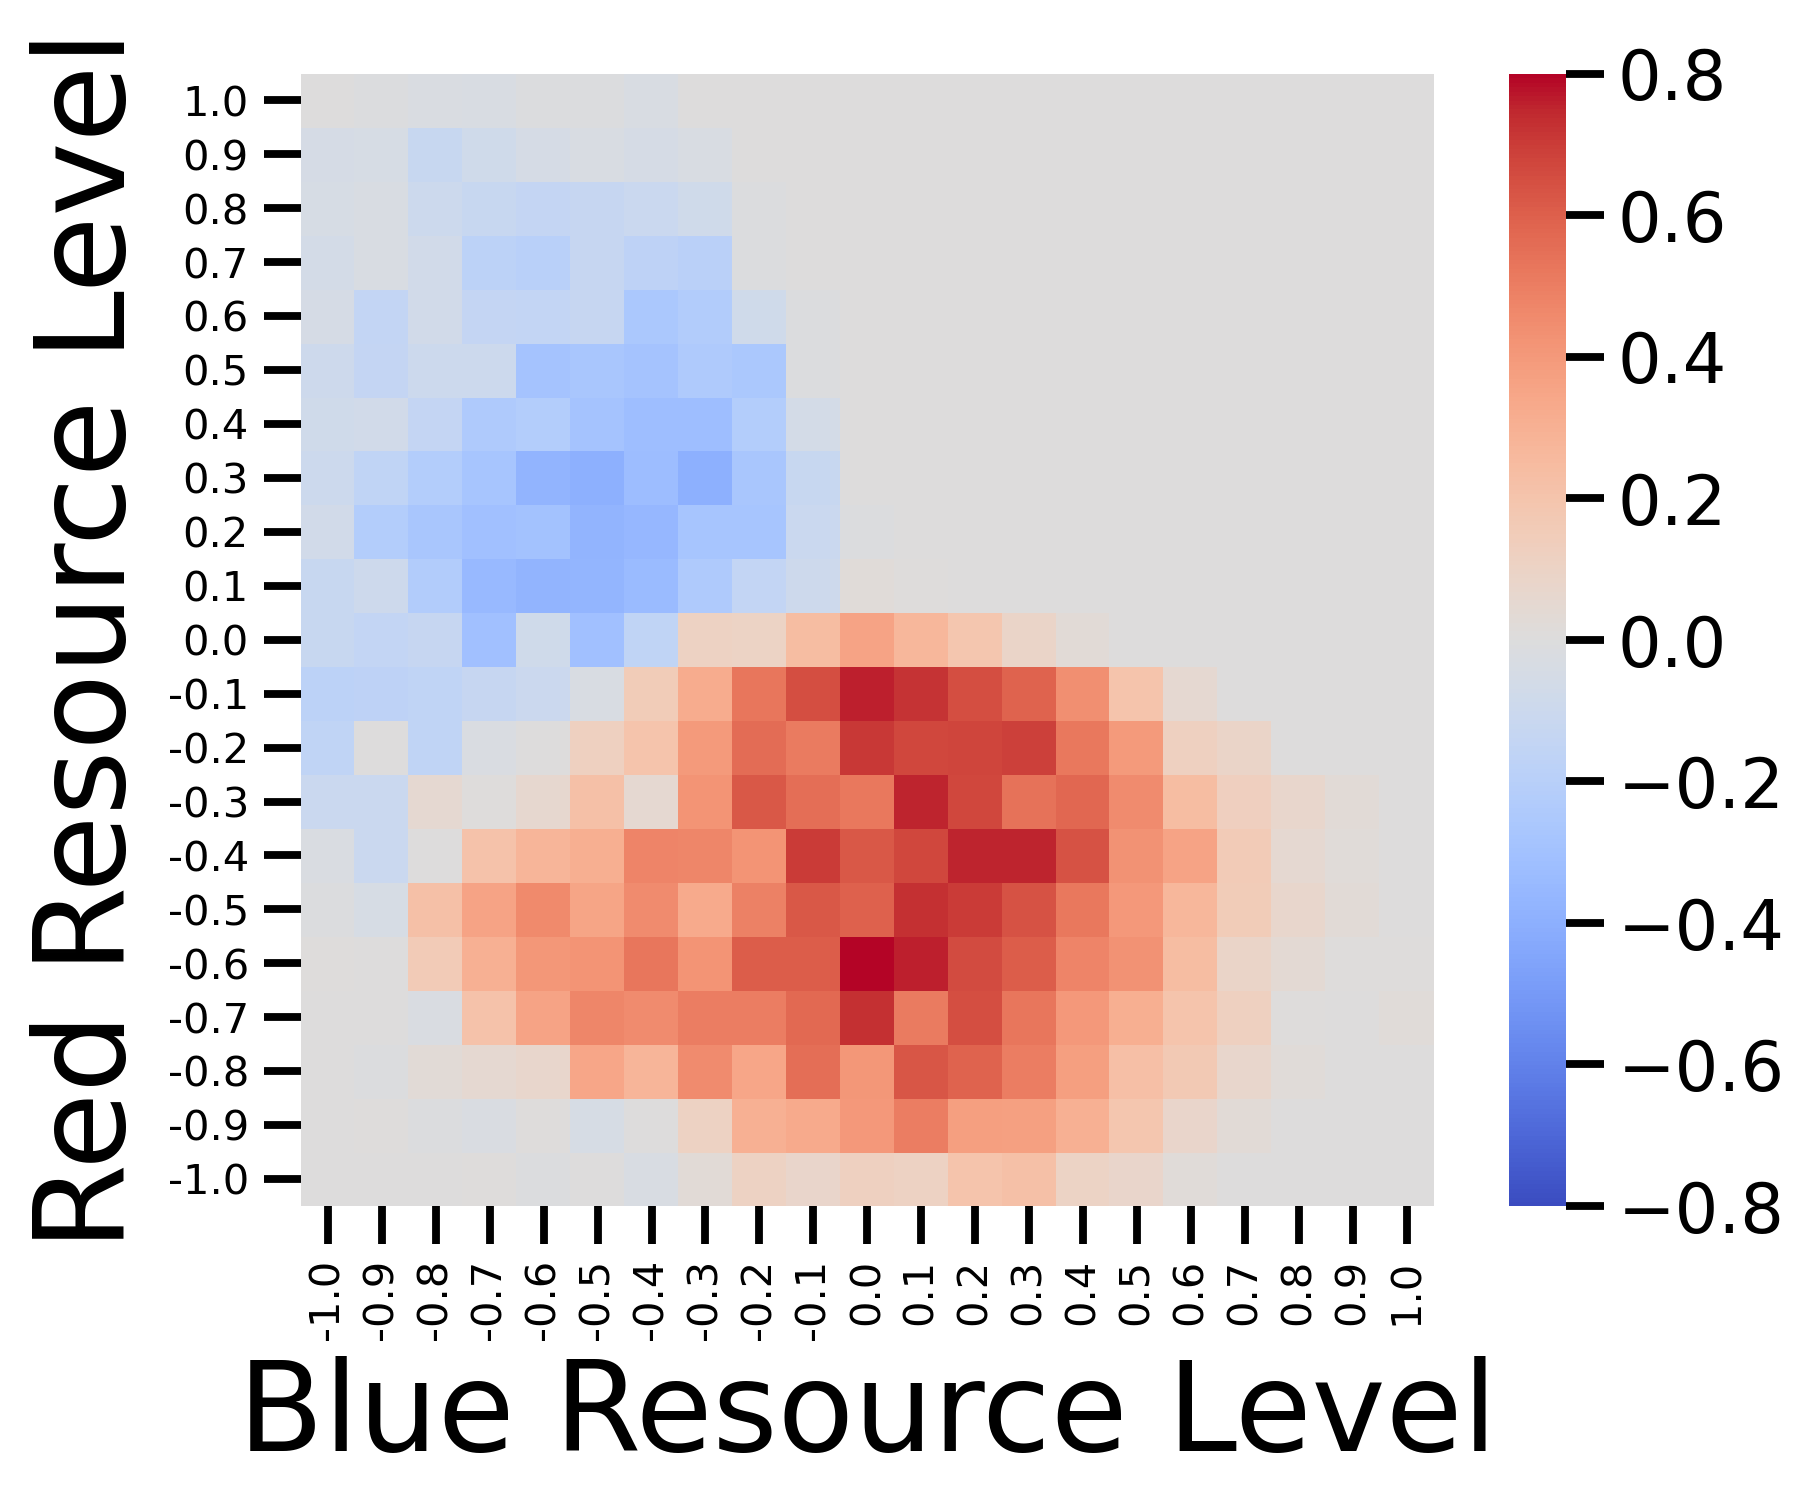

In [11]:
sns.set_context("talk")

N = 2

data_red_matrix = np.load(f"data_matrices_red_{N}_vision_full.npy")
data_blue_matrix = np.load(f"data_matrices_blue_{N}_vision_full.npy")

#########################################
# Red matrix
#########################################
plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(data_red_matrix.transpose(),
                 cmap="Reds", #"binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=10)

plt.savefig(f"red_matrix_vision_full_{N}.png", bbox_inches='tight')
plt.show()

#########################################
# Blue matrix
#########################################
plt.figure(figsize=(6.5, 5), dpi=300)
ax =sns.heatmap(data_blue_matrix.transpose(),
                cmap="Blues", #"binary_r",
                square=True,
                xticklabels=blue_ticks.round(2),
                yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=10)

plt.savefig(f"blue_matrix_vision_full_{N}.png", bbox_inches='tight')

#########################################
# Relative matrix
#########################################
plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix - data_blue_matrix).transpose(),
                 cmap='coolwarm',
                 center=0,
                 vmin=-0.8,
                 vmax=0.8,
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=10)

plt.savefig(f"ba_ratio_vision_full_{N}.png", bbox_inches='tight')

plt.show()

# Average Distribution

In [5]:
import numpy as np
from pathlib import Path

data_red_matrix_ave_6x4 = []
data_blue_matrix_ave_6x4 = []

for i in range(3):
    p = Path(".")
    
#     data_red_matrix_ave_6x4.append(np.load(p / f"data_matrices_red_{i}_vision_full.npy"))
#     data_blue_matrix_ave_6x4.append(np.load(p / f"data_matrices_blue_{i}_vision_full.npy"))
    data_red_matrix_ave_6x4.append(np.load(p / f"data_matrices_red_{i + 2}_vision_full.npy"))
    data_blue_matrix_ave_6x4.append(np.load(p / f"data_matrices_blue_{i + 2}_vision_full.npy"))
    
data_red_matrix_ave_6x4 = np.array(data_red_matrix_ave_6x4)
data_blue_matrix_ave_6x4 = np.array(data_blue_matrix_ave_6x4)

print(data_red_matrix_ave_6x4.shape)
print(data_blue_matrix_ave_6x4.shape)

(3, 21, 21)
(3, 21, 21)


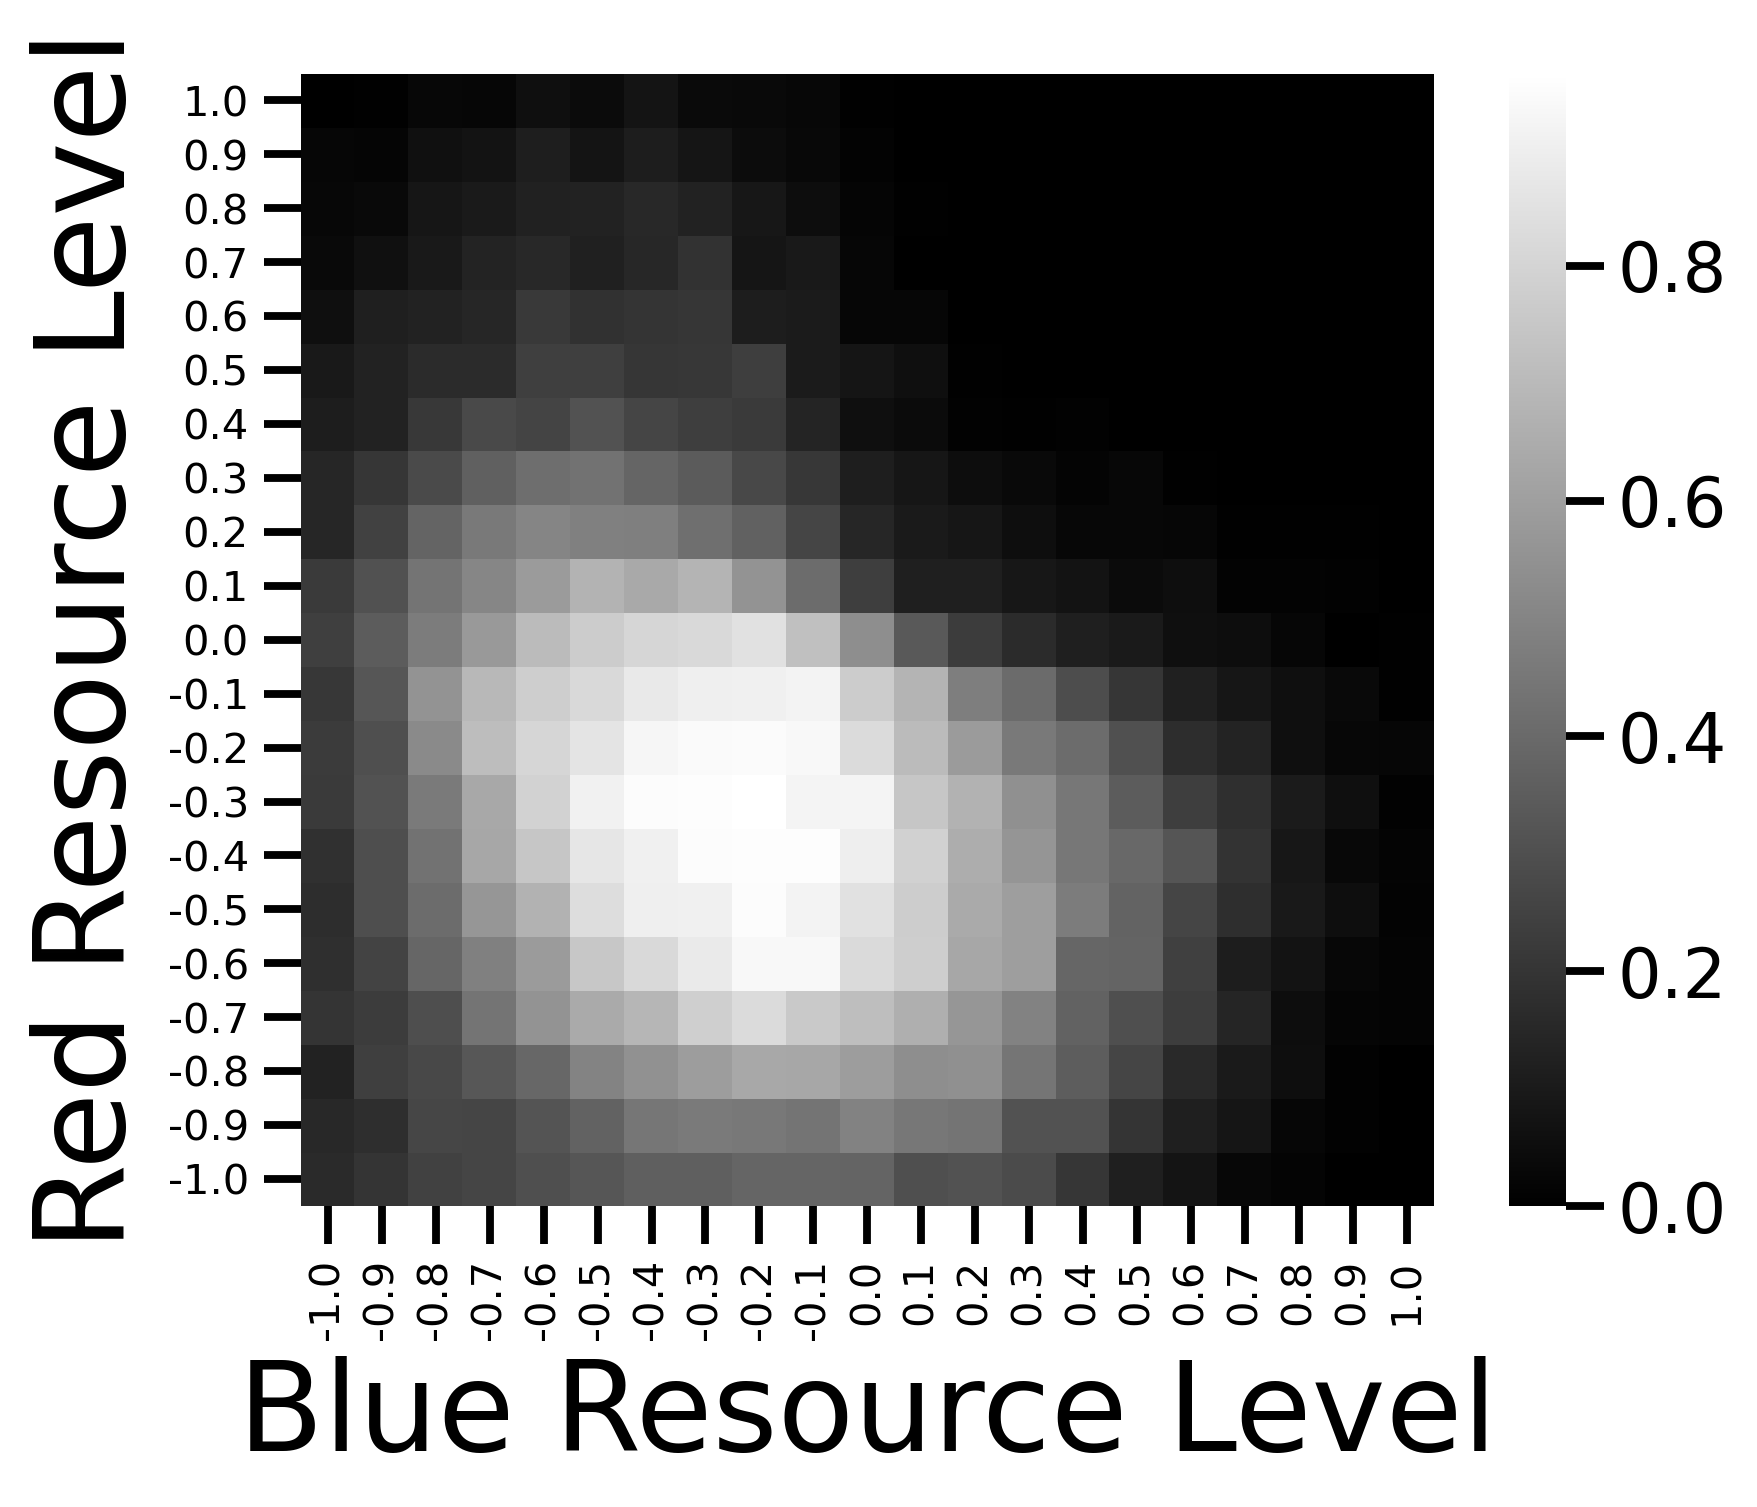

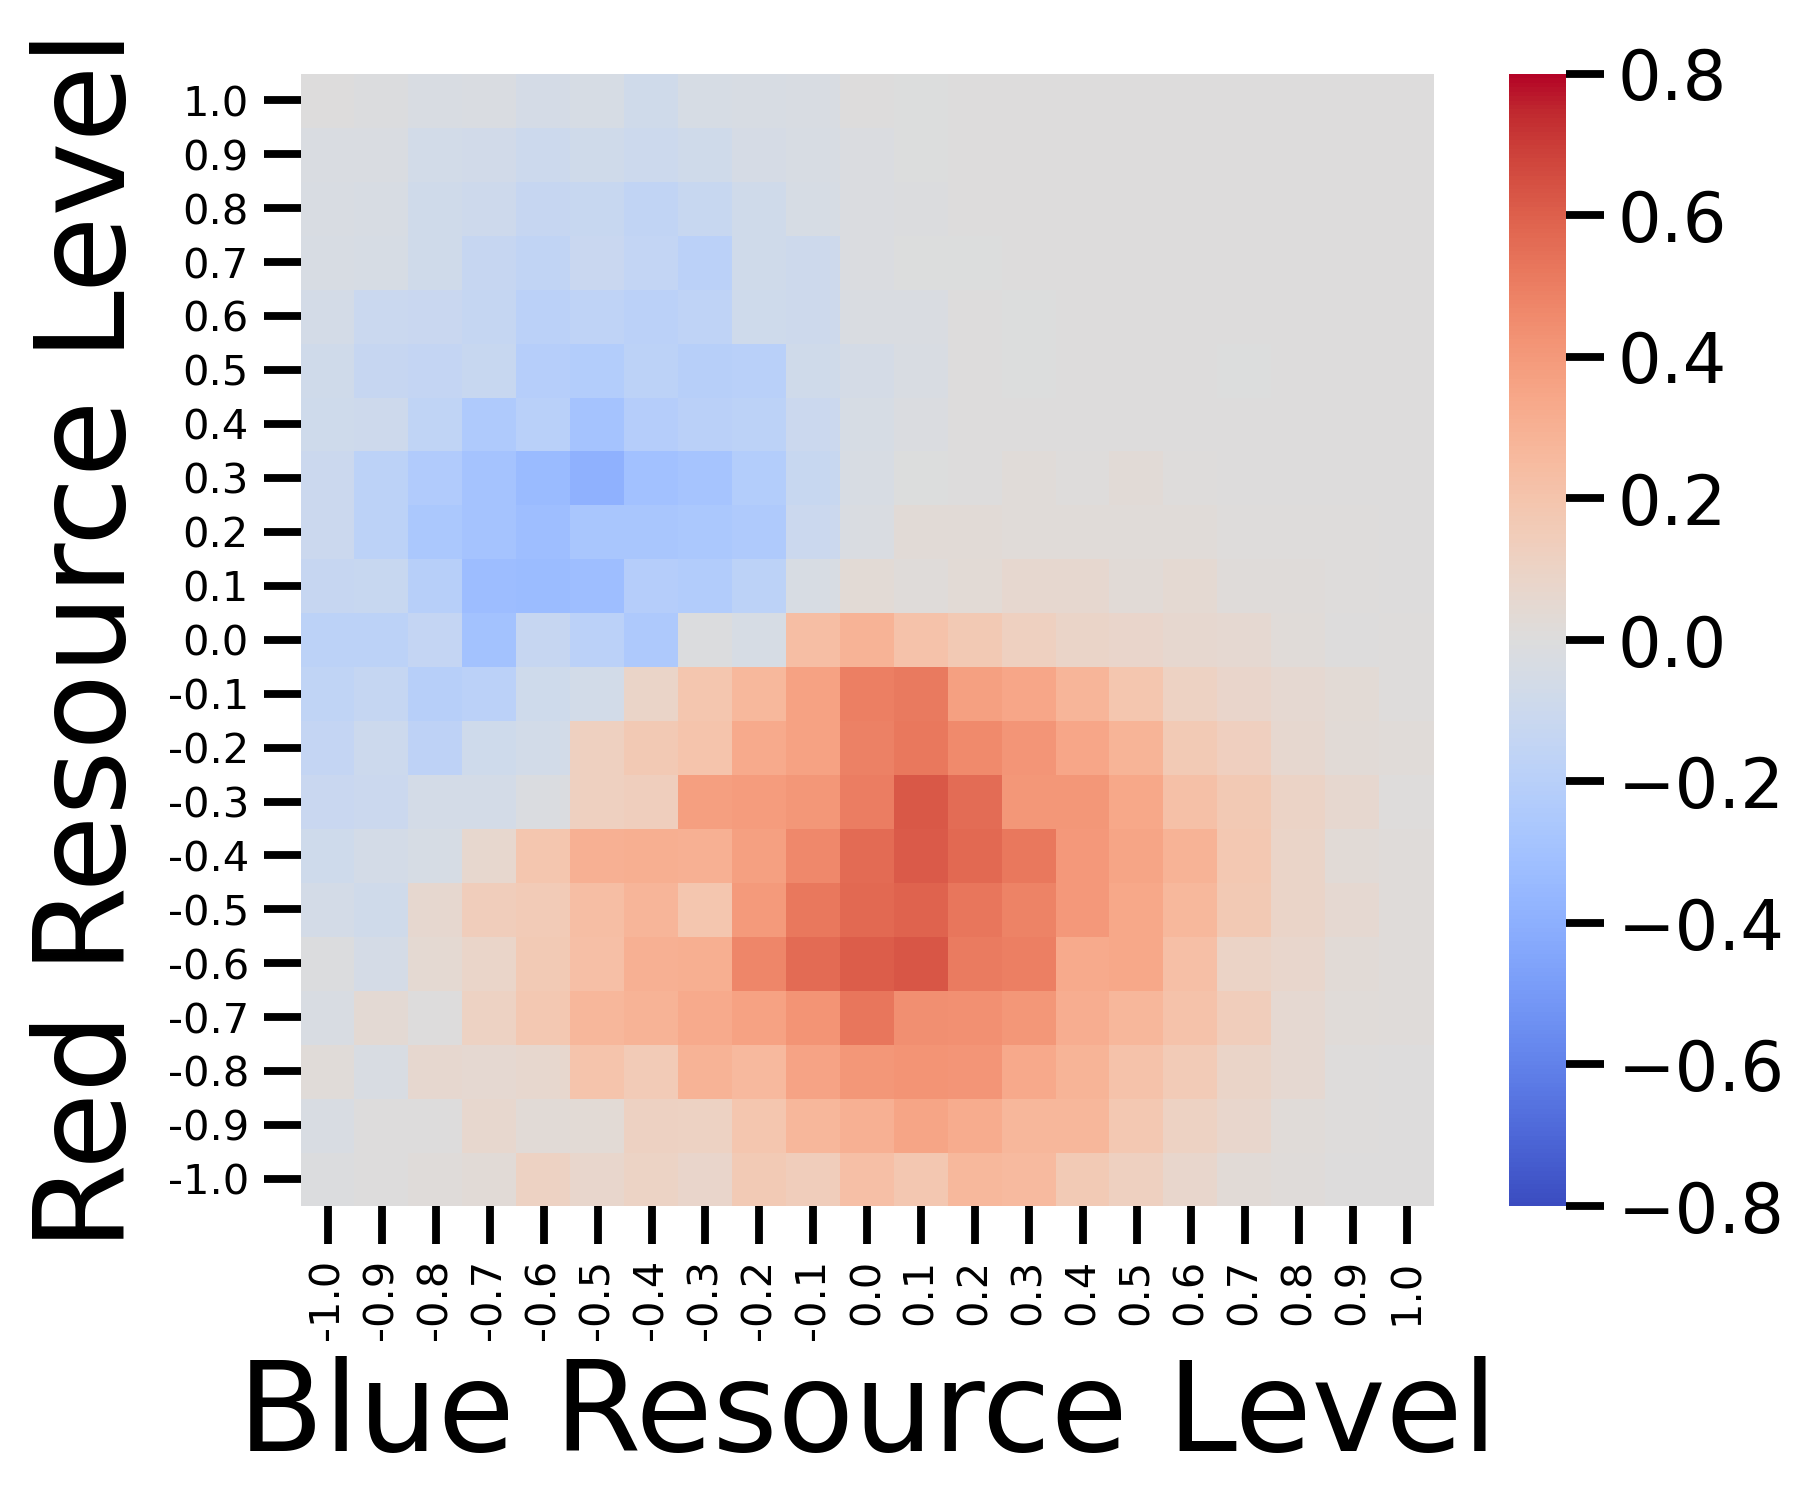

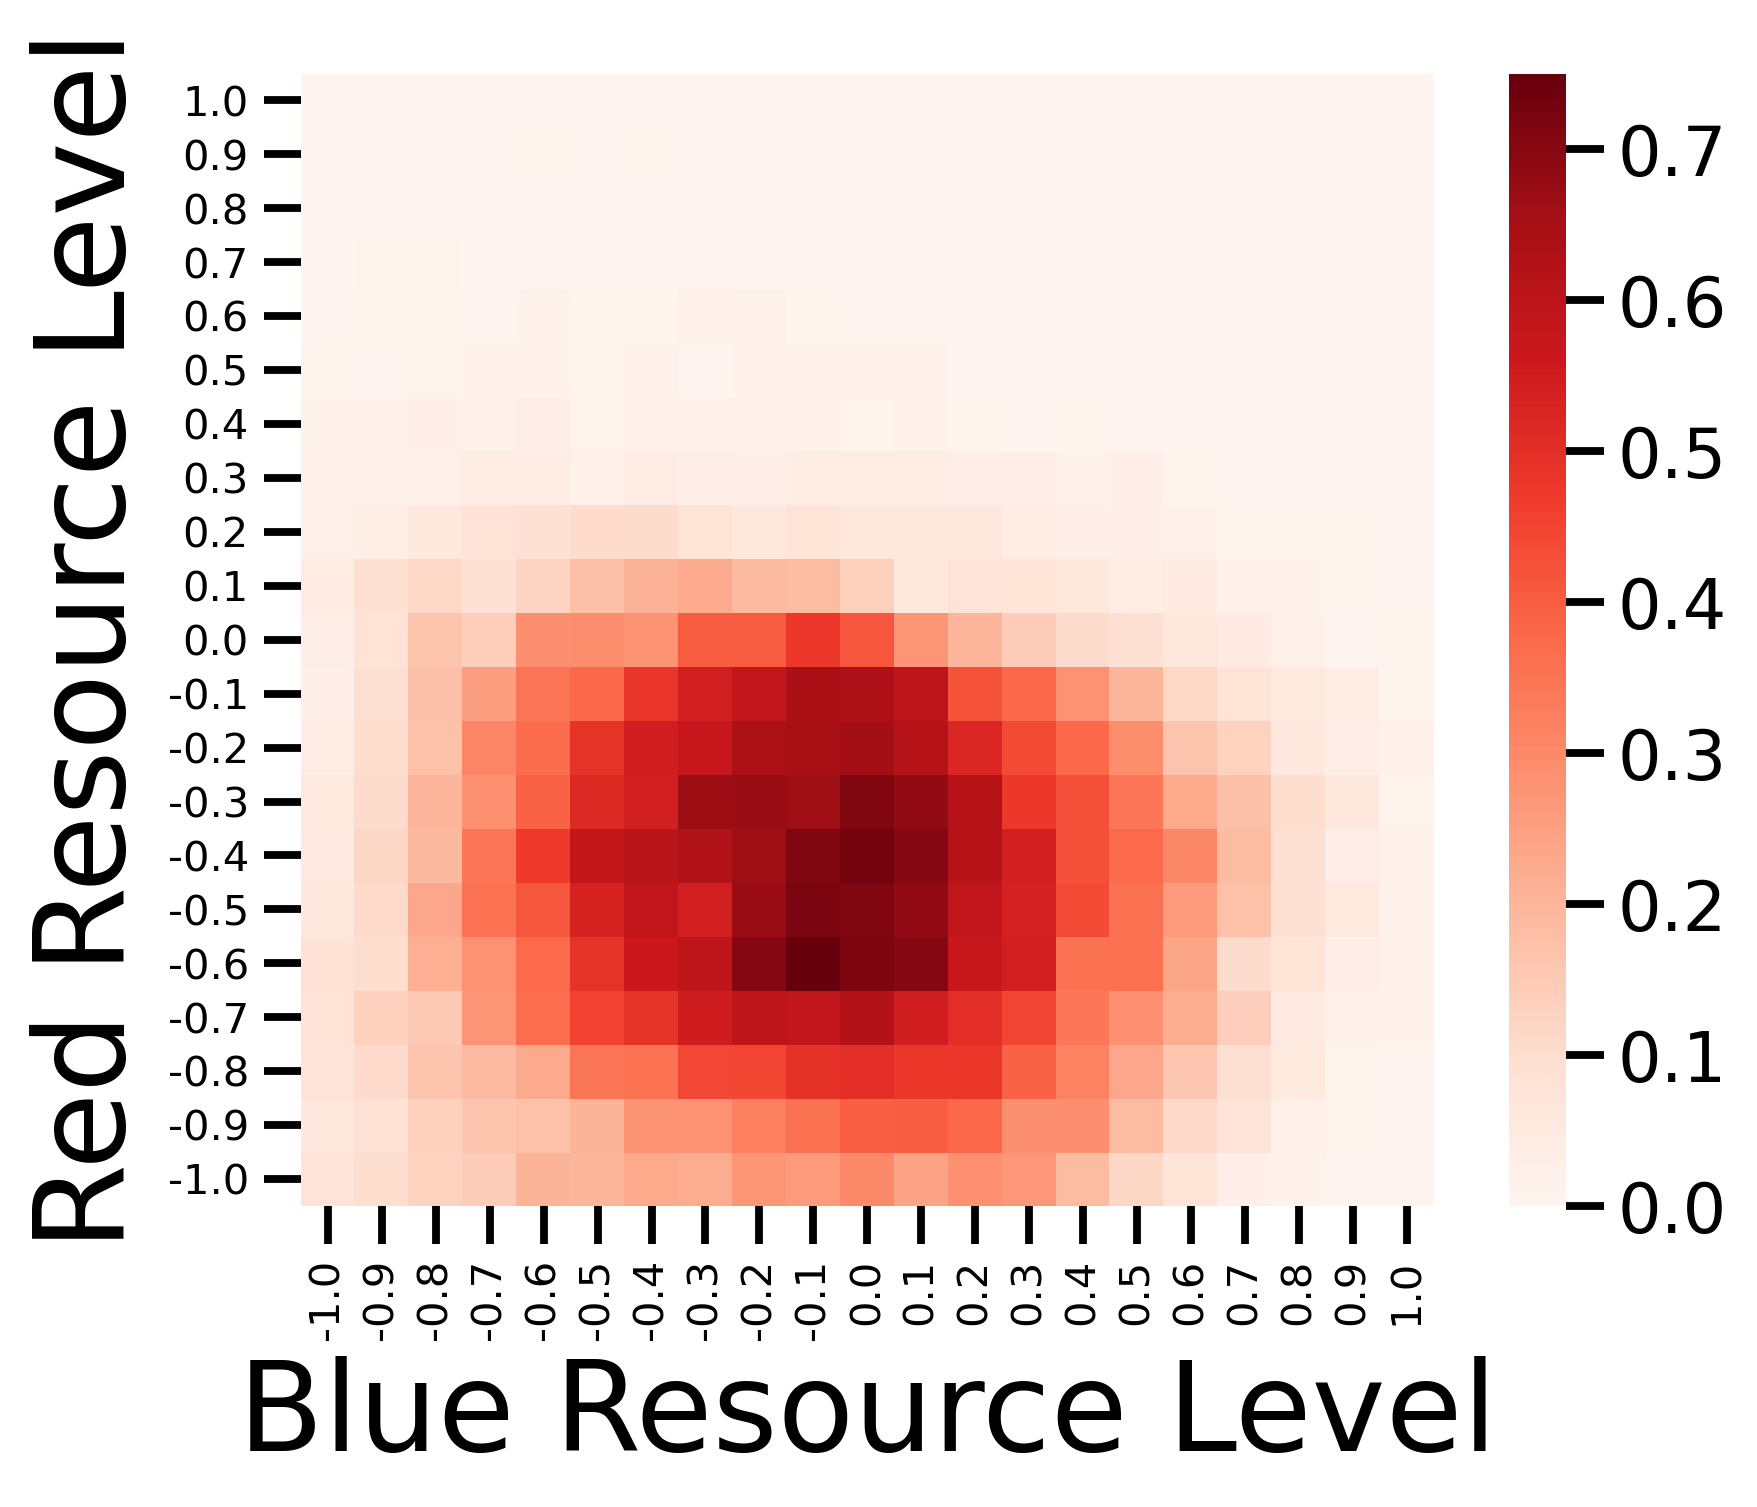

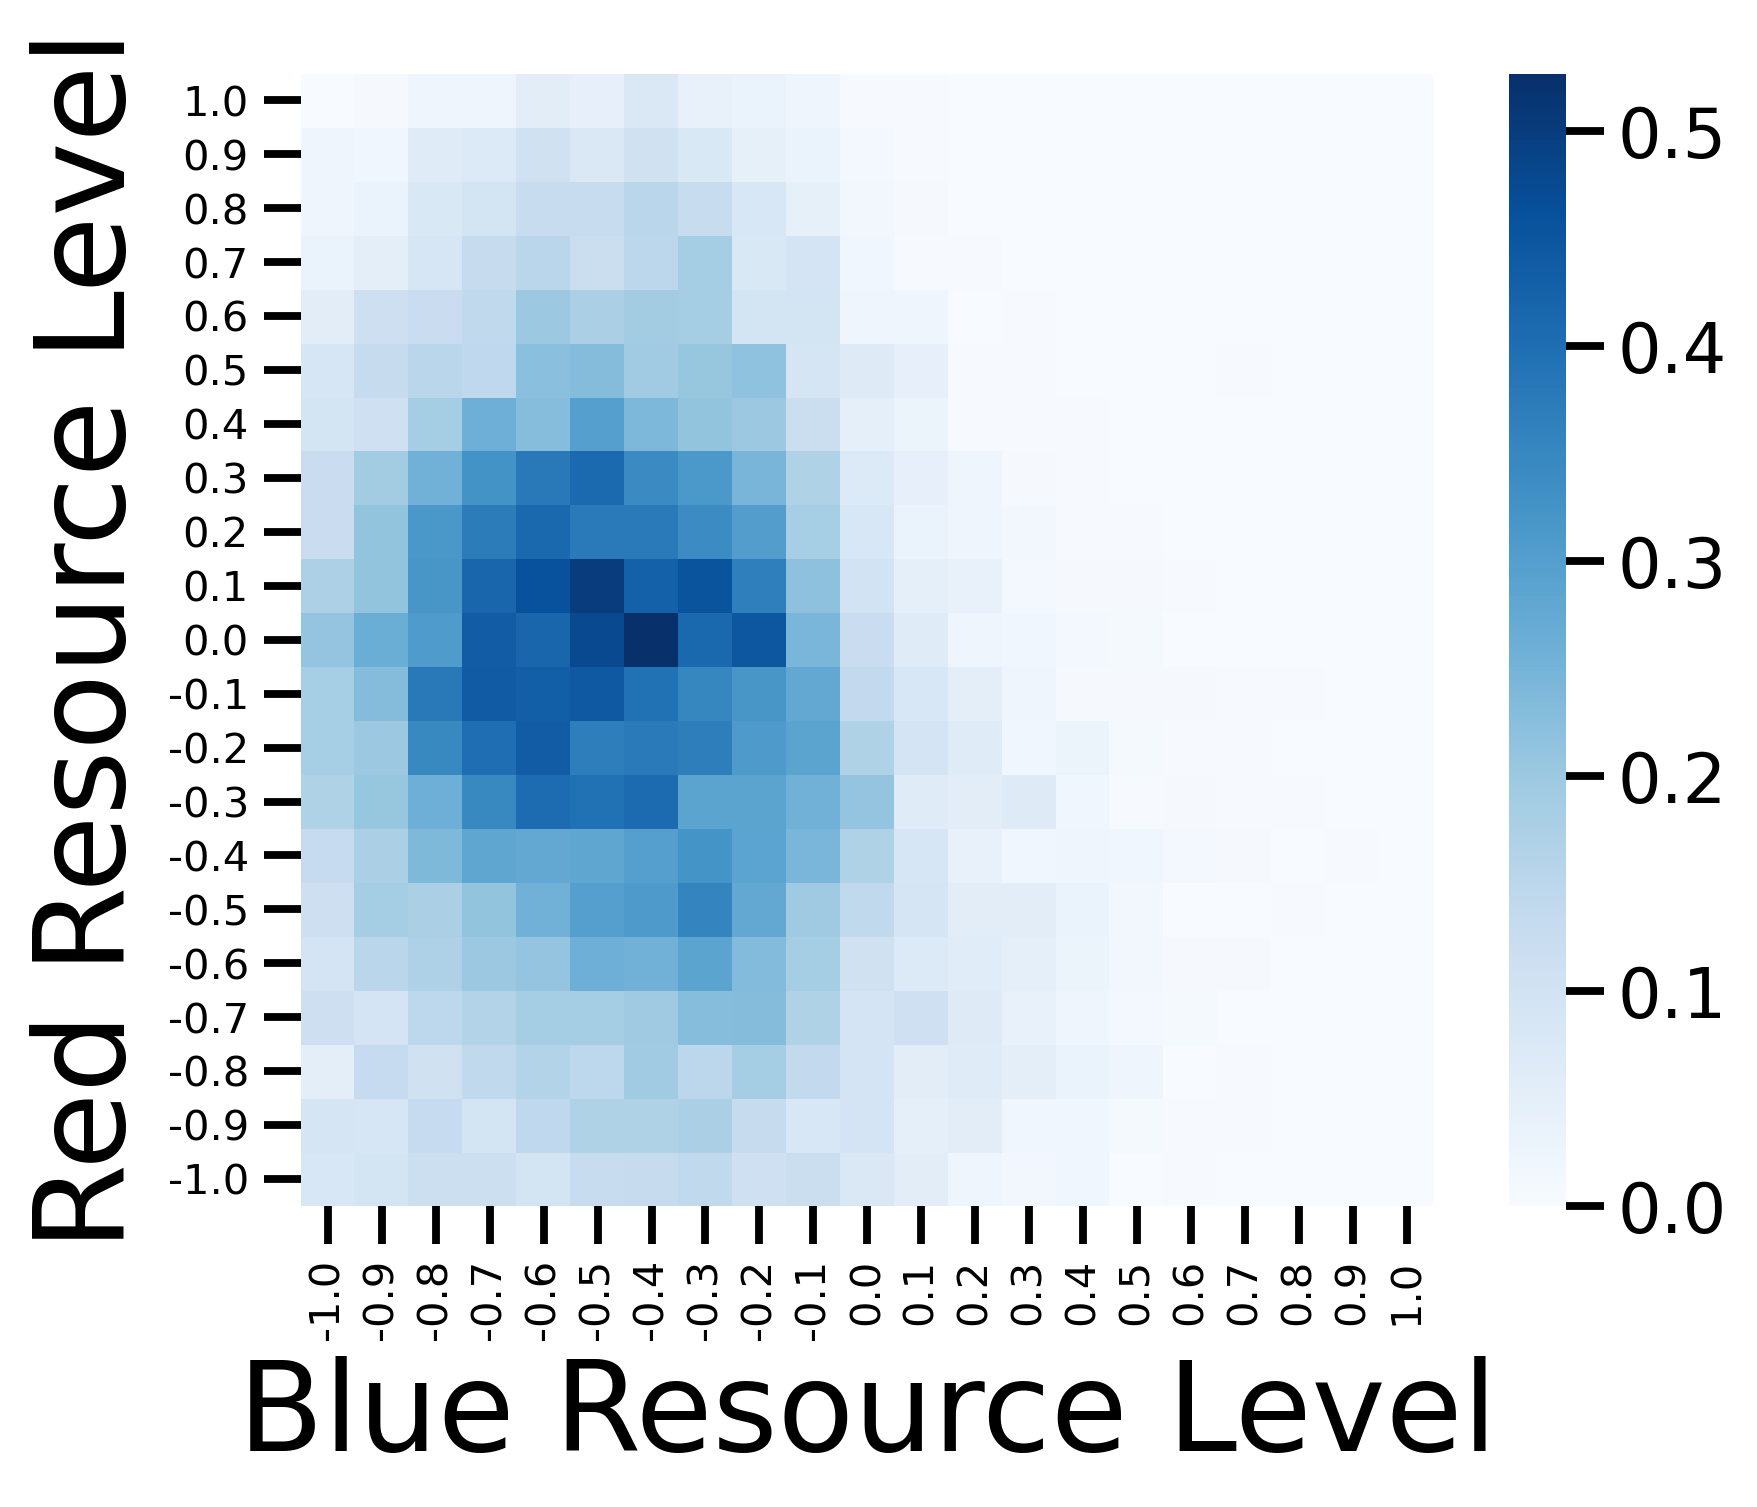

In [12]:
sns.set_context("talk")


plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_ave_6x4.mean(axis=0) + data_blue_matrix_ave_6x4.mean(axis=0)).transpose(),
                 cmap="binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=10)
ax.invert_yaxis()

plt.savefig("ba_collection_average_6x4_vision_full.png", bbox_inches='tight')



plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_ave_6x4.mean(axis=0) - data_blue_matrix_ave_6x4.mean(axis=0)).transpose(),
                 cmap='coolwarm',
                 center=0,
                 vmin=-0.8,
                 vmax=0.8,
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=10)

plt.savefig("ba_ratio_average_6x4_vision_full.png", bbox_inches='tight')



plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(data_red_matrix_ave_6x4.mean(axis=0).transpose(),
                 cmap="Reds", #"binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=10)

plt.savefig("red_matrix_average_6x4_vision_full.png", bbox_inches='tight')
plt.show()



plt.figure(figsize=(6.5, 5), dpi=300)
ax =sns.heatmap(data_blue_matrix_ave_6x4.mean(axis=0).transpose(),
                cmap="Blues", #"binary_r",
                square=True,
                xticklabels=blue_ticks.round(2),
                yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=10)

plt.savefig("blue_matrix_average_6x4_vision_full.png", bbox_inches='tight')


plt.show()

In [9]:
torch.cuda.is_available()

True